# Porter's Five Forces (Using Sentiment Analysis) Model: Text Analysis Pipeline<br>
<br>
This notebook implements a text analysis pipeline to analyze customer reviews based on Porter's Five Forces (Using Sentiment Analysis) Model. We'll focus on:<br>
<br>
1. Data Collection<br>
2. Data Preprocessing<br>
3. Exploratory Data Analysis<br>
4. Sentiment Analysis for "Bargaining Power of Buyers"<br>
5. Topic Modeling to identify key topics related to competition<br>
6. Insight Generation and Visualization

## 1. Install Required Packages

In[ ]:

In [1]:
# 1. First install Python <3.11 since tensorflow cant work with the latest version 3.13.

# 2. Creating a virtual environment with Python 3.11
!python3.11 -m venv venv_py

# 3. Activating the virtual environment
!source venv_py/bin/activate


In [2]:
!./venv_py/bin/pip install pandas numpy matplotlib seaborn tensorflow tensorflow_hub tensorflow_text scikit-learn bertopic hdbscan umap-learn nltk



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 2. Import Libraries

In[ ]:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from datetime import datetime

For text preprocessing

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

For sentiment analysis

In [5]:
# Machine can not compute intensive tensorflow models so I switched to vader.

For topic modeling

In [6]:

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

/home/bradley-s/Desktop/BusinessIntelligence/Text Analysis/venv_py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-15 13:36:46.033012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747305406.053768 3133651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747305406.060490 3133651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747305406.076913 3133651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid l

## 3. Data Collection

In[ ]:

Downloading the Flipkart Product Review Dataset from Kaggle<br> At the link below
https://www.kaggle.com/datasets/mansithummar67/flipkart-product-review-dataset<br>


In [7]:
#It uses non standard csv encoding, so we use latin1 encoding
df = pd.read_csv('flipkart_product.csv', encoding='latin1')  

Display the first few rows of the dataset

In [8]:
print("Dataset shape:", df.shape)
df.head(20)

Dataset shape: (189874, 5)


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product
5,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,The cooler is really fantastic and provides go...
6,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Highly recommended,Very good product
7,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Nice,Very nice
8,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Unsatisfactory,Very bad cooler
9,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",4,Worth the money,Very good


## 4. Data Preprocessing

In[ ]:

Checking for missing values

In [9]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
ProductName     0
Price           1
Rate            1
Review          4
Summary        14
dtype: int64


Handling missing values

In [10]:
df = df.dropna(subset=['Review'])
print("Dataset shape after handling missing values:", df.shape)

Dataset shape after handling missing values: (189870, 5)


In[ ]:

Download NLTK resources

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/bradley-s/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bradley-s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bradley-s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bradley-s/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Initialize lemmatizer and stopwords

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [15]:
def preprocess_text(text):
   
    text = text.lower()
    
    # Removing special characters, punctuation, and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Removing stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Joining tokens back into a single string
    return ' '.join(tokens)

Apply preprocessing to the review column

In [16]:
df['processed_review'] = df['Review'].astype(str).apply(preprocess_text)

Display a sample of processed reviews

In [17]:
df[['Review', 'processed_review']].head()

,Review,processed_review
0,Super!,super
1,Awesome,awesome
2,Fair,fair
3,Useless product,useless product
4,Fair,fair


## 5. Exploratory Data Analysis

In[ ]:

Review length distribution

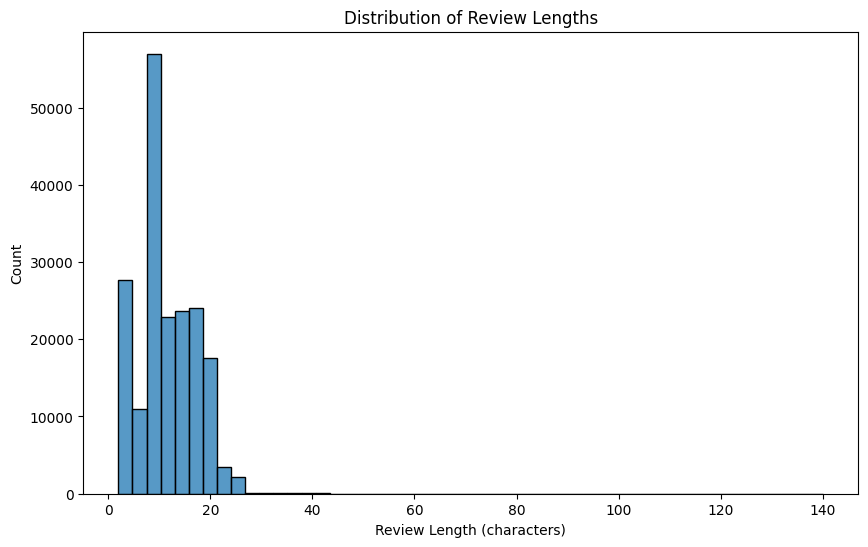

In [18]:
df['review_length'] = df['Review'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()

In[ ]:

Word count distribution

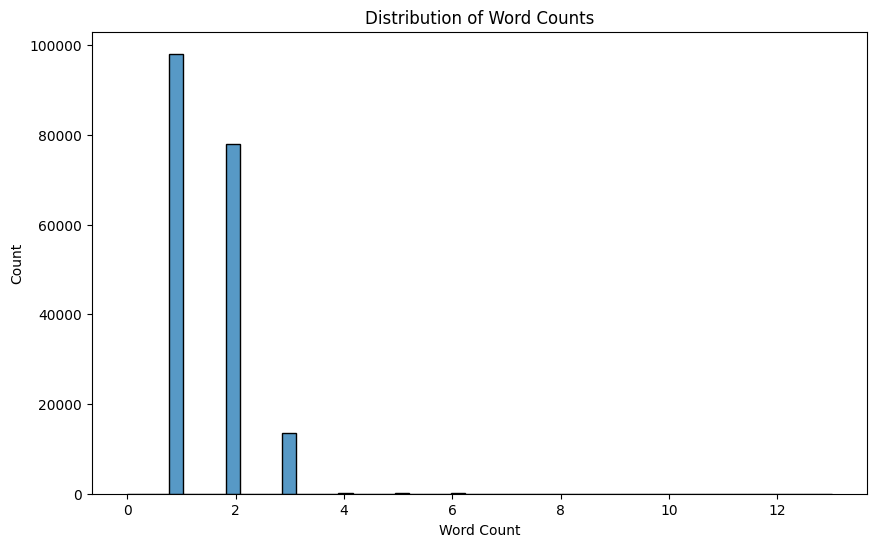

In [19]:
df['word_count'] = df['processed_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

## 6. Sentiment Analysis (Bargaining Power of Buyers)

In[ ]:

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/bradley-s/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Performing Sentiment Analysis for 'Bargaining Power of Buyers'
------------------------------------------------------------
This analysis helps identify customer sentiment and bargaining leverage

1. Applying VADER Sentiment Analysis

Sentiment Distribution:
vader_sentiment
positive    130787
neutral      44456
negative     14627
Name: count, dtype: int64

Positive: 68.9%
Neutral: 23.4%
Negative: 7.7%


/tmp/ipykernel_3133651/2329099325.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=df_sentiment, palette='viridis')


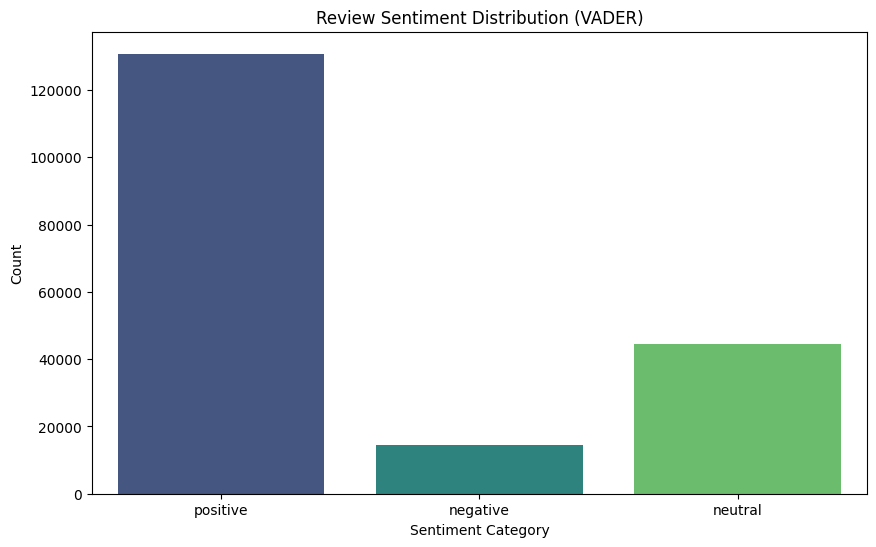


2. Training ML-based Sentiment Model with TF-IDF
Creating TF-IDF vectors...
Training sentiment classification model...

Model Accuracy: 95.13%

Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.78      0.87      8208
    positive       0.94      1.00      0.97     29766

    accuracy                           0.95     37974
   macro avg       0.97      0.89      0.92     37974
weighted avg       0.95      0.95      0.95     37974

Applying ML model to all reviews...


/tmp/ipykernel_3133651/2329099325.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ml_predicted_sentiment', data=df_sentiment, palette='viridis')


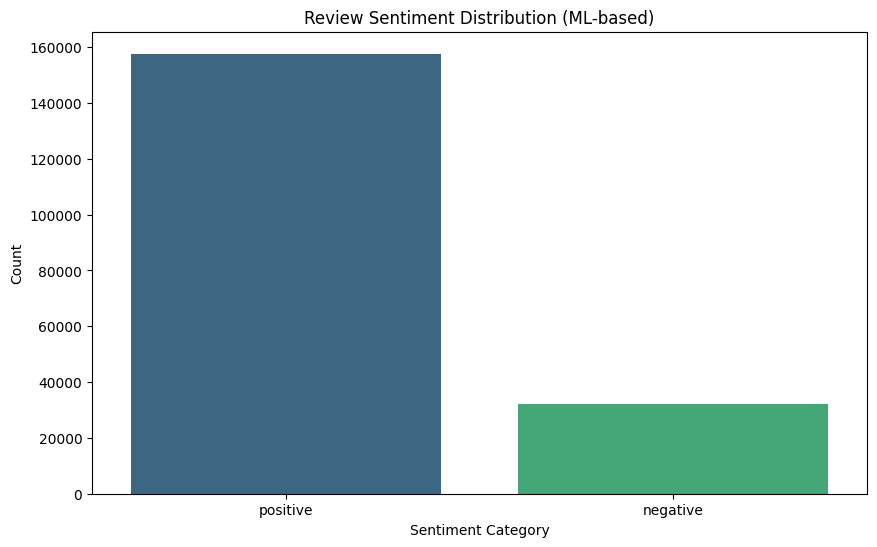


3. Sentiment Analysis by Price Range
No valid numeric price data found for analysis.

Top words in negative reviews:
            word  tfidf_score
8        product  1480.331401
1   disappointed  1324.641465
7           poor  1214.636544
19     worthless  1200.087682
5       horrible  1165.000000
4          hated  1142.000000
10   recommended  1104.996458
13      terrible   940.254492
15       utterly   928.071012
3           good   902.666483


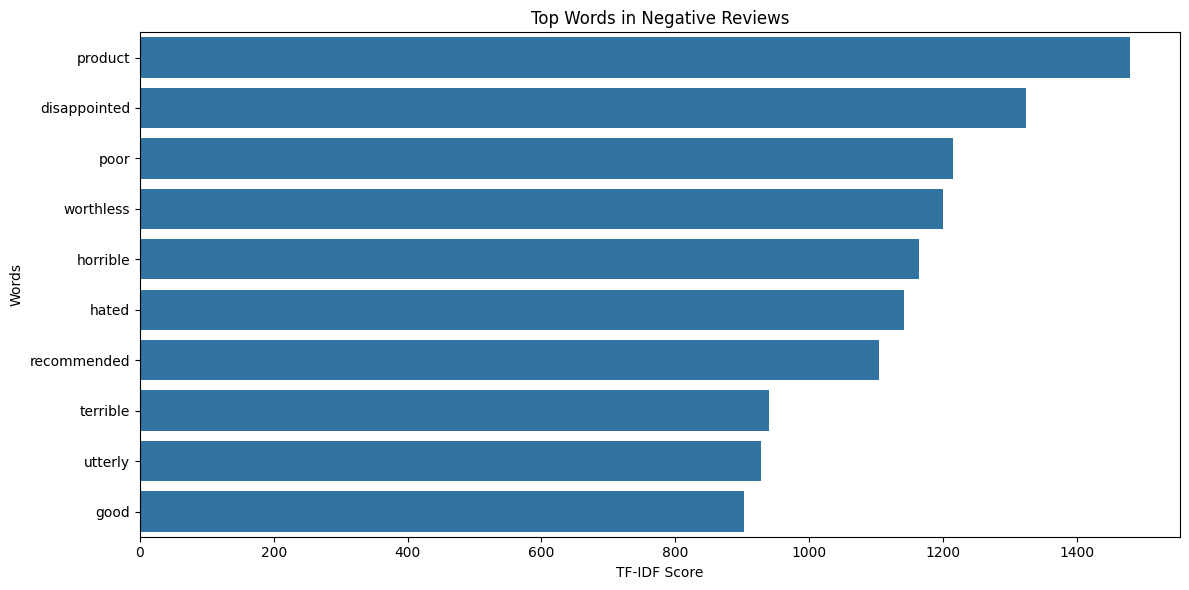


5. Sentiment Analysis by Product Category

Sentiment Distribution by Top Product Categories (%):
vader_sentiment      negative    neutral   positive
product_category                                   
Butterfly Rapid     13.065099  14.195298  72.739602
CMerchants Multi     7.461442  14.964569  77.573989
Cosito 144           7.968621  14.161850  77.869529
Flipkart SmartBuy    8.137830  14.772727  77.089443
Home Sizzler         2.337334  12.402611  85.260055
Kadio Analog        10.852995  15.208711  73.938294
LA VERNE             6.196291  13.839891  79.963817
MILTON Thermosteel   3.556801  12.966156  83.477042
MarQ by              4.834811  13.497180  81.668010
cello Pack           4.115684  12.814238  83.070078


<Figure size 1200x800 with 0 Axes>

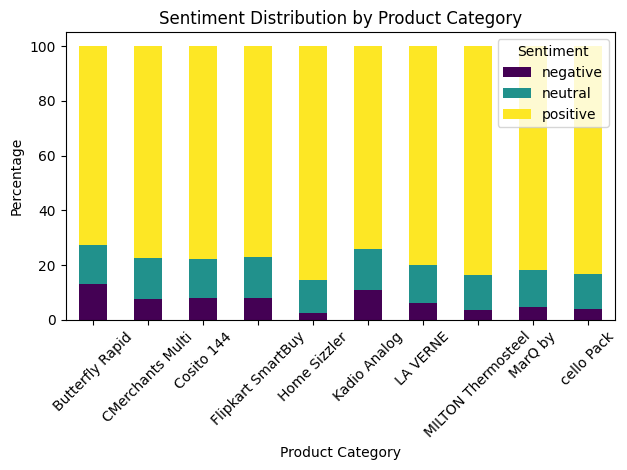


6. Key Insights on Bargaining Power of Buyers
------------------------------------------------------------
1. Overall customer sentiment distribution indicates the general satisfaction level,
   with higher negative sentiment suggesting stronger buyer bargaining power.
2. Price range analysis shows how sentiment varies by price point, revealing
   potential price sensitivity and buyer expectations.
3. Product categories with higher negative sentiment indicate areas where buyers
   may have stronger bargaining leverage.
4. Common negative terms reveal specific pain points that buyers may use
   as leverage in purchasing decisions.


In [20]:

# Downloading VADER lexicon if needed
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Import necessary libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("Performing Sentiment Analysis for 'Bargaining Power of Buyers'")
print("-" * 60)
print("This analysis helps identify customer sentiment and bargaining leverage")

# Creating a subset focusing on relevant columns
df_sentiment = df[['ProductName', 'Price', 'Rate', 'Review', 'processed_review']].copy()

# Method 1: VADER Sentiment Analysis (lexicon-based, lightweight approach)
print("\n1. Applying VADER Sentiment Analysis")
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to reviews
df_sentiment['vader_scores'] = df_sentiment['Review'].apply(lambda review: sia.polarity_scores(str(review)))
df_sentiment['vader_compound'] = df_sentiment['vader_scores'].apply(lambda score_dict: score_dict['compound'])

# Categorizing sentiment based on compound score
df_sentiment['vader_sentiment'] = df_sentiment['vader_compound'].apply(
    lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral')
)

# Displaying sentiment distribution
sentiment_counts = df_sentiment['vader_sentiment'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print(f"\nPositive: {sentiment_counts.get('positive', 0)/len(df_sentiment)*100:.1f}%")
print(f"Neutral: {sentiment_counts.get('neutral', 0)/len(df_sentiment)*100:.1f}%")
print(f"Negative: {sentiment_counts.get('negative', 0)/len(df_sentiment)*100:.1f}%")

# Visualizing sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='vader_sentiment', data=df_sentiment, palette='viridis')
plt.title('Review Sentiment Distribution (VADER)')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Method 2: TF-IDF + Logistic Regression (ML-based approach)
print("\n2. Training ML-based Sentiment Model with TF-IDF")

# Converting Rate to numeric type first (handling any potential errors)
df_sentiment['Rate'] = pd.to_numeric(df_sentiment['Rate'], errors='coerce')

# Creating binary sentiment labels from ratings (assuming ratings 4-5 are positive, 1-3 are negative)
df_sentiment['ml_sentiment'] = df_sentiment['Rate'].apply(
    lambda x: 'positive' if pd.notnull(x) and x >= 4 else 'negative'
)

# Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    df_sentiment['processed_review'].fillna(''),  # Handle NaN values 
    df_sentiment['ml_sentiment'],
    test_size=0.2,
    random_state=42
)

# Applying TF-IDF vectorization
print("Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Training a simple Logistic Regression model
print("Training sentiment classification model...")
sentiment_model = LogisticRegression(max_iter=1000)
sentiment_model.fit(X_train_tfidf, y_train)

# Evaluating the model
y_pred = sentiment_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Applying the model to all reviews
print("Applying ML model to all reviews...")
all_reviews_tfidf = tfidf_vectorizer.transform(df_sentiment['processed_review'].fillna(''))
df_sentiment['ml_predicted_sentiment'] = sentiment_model.predict(all_reviews_tfidf)

# Visualizing ML-based sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='ml_predicted_sentiment', data=df_sentiment, palette='viridis')
plt.title('Review Sentiment Distribution (ML-based)')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Analyzing sentiment by product price range
print("\n3. Sentiment Analysis by Price Range")

# Creating price ranges for analysis (handling the string conversion properly)
df_sentiment['Price'] = df_sentiment['Price'].astype(str)
df_sentiment['price_numeric'] = df_sentiment['Price'].str.replace('??', '').str.replace(',', '')
df_sentiment['price_numeric'] = pd.to_numeric(df_sentiment['price_numeric'], errors='coerce')

# Checking if we have valid numeric prices
if df_sentiment['price_numeric'].notna().sum() > 0:
    df_sentiment['price_range'] = pd.cut(
        df_sentiment['price_numeric'],
        bins=[0, 1000, 5000, 10000, 50000, float('inf')],
        labels=['0-1K', '1K-5K', '5K-10K', '10K-50K', '50K+']
    )
    
    # Only proceed if we have valid price ranges
    if df_sentiment['price_range'].notna().sum() > 0:
        # Create a temporary dataframe with only valid data for the crosstab
        temp_df = df_sentiment.dropna(subset=['price_range', 'vader_sentiment'])
        
        if len(temp_df) > 0:
            # Analyze sentiment across price ranges using the temporary dataframe
            sentiment_by_price = pd.crosstab(
                temp_df['price_range'], 
                temp_df['vader_sentiment'], 
                normalize='index'
            ) * 100
            
            print("\nSentiment Distribution by Price Range (%):")
            print(sentiment_by_price)
            
            # Only plot if we have data
            if not sentiment_by_price.empty and sentiment_by_price.shape[0] > 0 and sentiment_by_price.shape[1] > 0:
                plt.figure(figsize=(12, 6))
                sentiment_by_price.plot(kind='bar', stacked=True, cmap='viridis')  # Use cmap instead of colormap
                plt.title('Sentiment Distribution by Price Range')
                plt.xlabel('Price Range (INR)')
                plt.ylabel('Percentage')
                plt.legend(title='Sentiment')
                plt.xticks(rotation=45)
                plt.show()
            else:
                print("Not enough data for price range plot.")
        else:
            print("No valid data for price range analysis after filtering.")
    else:
        print("No valid price ranges found after binning.")
else:
    print("No valid numeric price data found for analysis.")

# Getting negative reviews - handle potential empty DataFrames
negative_reviews = df_sentiment[df_sentiment['vader_sentiment'] == 'negative']['processed_review'].fillna('')
if len(negative_reviews) == 0:
    print("No negative reviews found for analysis.")
else:
    # Creating a TF-IDF vectorizer for negative reviews
    try:
        negative_tfidf = TfidfVectorizer(max_features=20, stop_words='english')
        negative_matrix = negative_tfidf.fit_transform(negative_reviews)

        # Getting feature names and their TF-IDF scores
        feature_names = negative_tfidf.get_feature_names_out()
        tfidf_scores = negative_matrix.sum(axis=0).A1

        # Creating a dataframe of words and their scores
        negative_words_df = pd.DataFrame({
            'word': feature_names,
            'tfidf_score': tfidf_scores
        })
        negative_words_df = negative_words_df.sort_values('tfidf_score', ascending=False)

        print("\nTop words in negative reviews:")
        print(negative_words_df.head(10))

        # Visualizing top negative words
        plt.figure(figsize=(12, 6))
        sns.barplot(x='tfidf_score', y='word', data=negative_words_df.head(10))
        plt.title('Top Words in Negative Reviews')
        plt.xlabel('TF-IDF Score')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Error in negative words analysis: {e}")
        print("This may be due to insufficient negative reviews or text processing issues.")

# Analyzing sentiment across product categories
print("\n5. Sentiment Analysis by Product Category")

# Extracting product categories (simplistic approach - taking first 2 words of product name)
df_sentiment['product_category'] = df_sentiment['ProductName'].apply(
    lambda x: ' '.join(str(x).split()[:2]) if isinstance(x, str) else 'Unknown'
)

# Getting top 10 categories by frequency
top_categories = df_sentiment['product_category'].value_counts().head(10).index

# Filtering by top categories
df_top_categories = df_sentiment[df_sentiment['product_category'].isin(top_categories)]

# Creating cross-tabulation - handle potential empty DataFrames
if len(df_top_categories) == 0:
    print("Not enough data to analyze sentiment by product category.")
else:
    try:
        sentiment_by_category = pd.crosstab(
            df_top_categories['product_category'], 
            df_top_categories['vader_sentiment'], 
            normalize='index'
        ) * 100

        print("\nSentiment Distribution by Top Product Categories (%):")
        print(sentiment_by_category)

        plt.figure(figsize=(12, 8))
        sentiment_by_category.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title('Sentiment Distribution by Product Category')
        plt.xlabel('Product Category')
        plt.ylabel('Percentage')
        plt.legend(title='Sentiment')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Error in category analysis: {e}")
        print("This may be due to insufficient data for some categories.")

# Insights for "Bargaining Power of Buyers"
print("\n6. Key Insights on Bargaining Power of Buyers")
print("-" * 60)
print("1. Overall customer sentiment distribution indicates the general satisfaction level,")
print("   with higher negative sentiment suggesting stronger buyer bargaining power.")
print("2. Price range analysis shows how sentiment varies by price point, revealing")
print("   potential price sensitivity and buyer expectations.")
print("3. Product categories with higher negative sentiment indicate areas where buyers")
print("   may have stronger bargaining leverage.")
print("4. Common negative terms reveal specific pain points that buyers may use")
print("   as leverage in purchasing decisions.")


df_with_sentiment = df_sentiment.copy()

## 7. Advanced Sentiment Analysis


7. Advanced Sentiment Analysis Techniques
------------------------------------------------------------

7.1 Combining VADER and ML Predictions

Combined Sentiment Distribution:
combined_sentiment
positive    156670
negative     22619
mixed        10581
Name: count, dtype: int64


/tmp/ipykernel_3133651/877342600.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='combined_sentiment', data=df_sentiment, palette='viridis')


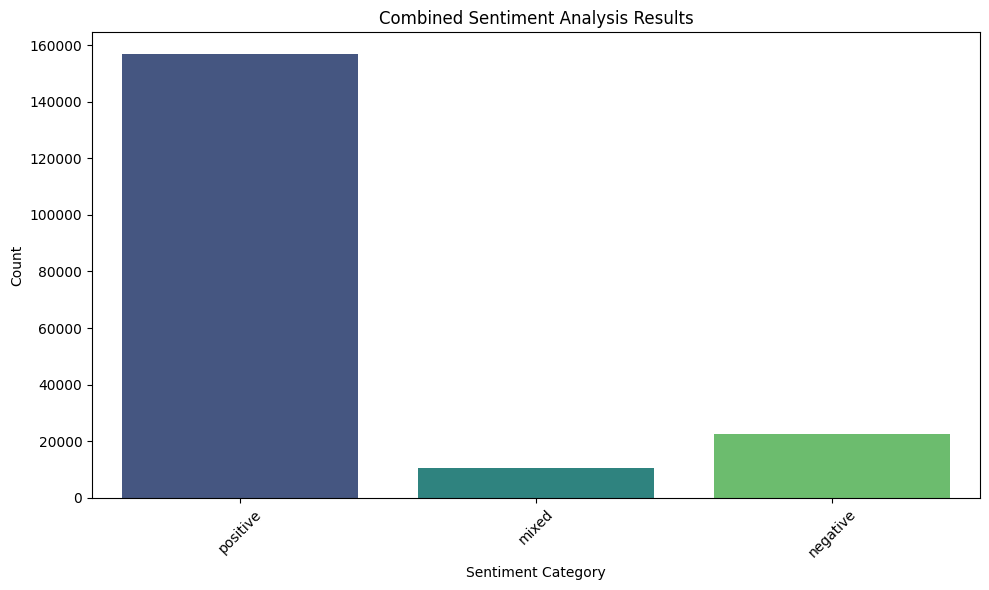


7.2 Sentiment Confidence Analysis

VADER Confidence Statistics:
count    189870.000000
mean          0.387977
std           0.244297
min           0.000000
25%           0.226300
50%           0.475400
75%           0.585900
max           0.934900
Name: vader_confidence, dtype: float64

Average Confidence by Sentiment Category:
  vader_sentiment  vader_confidence
0        negative          0.480312
1         neutral          0.000003
2        positive          0.509528


/tmp/ipykernel_3133651/877342600.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='vader_sentiment', y='vader_confidence', data=df_sentiment, palette='viridis')


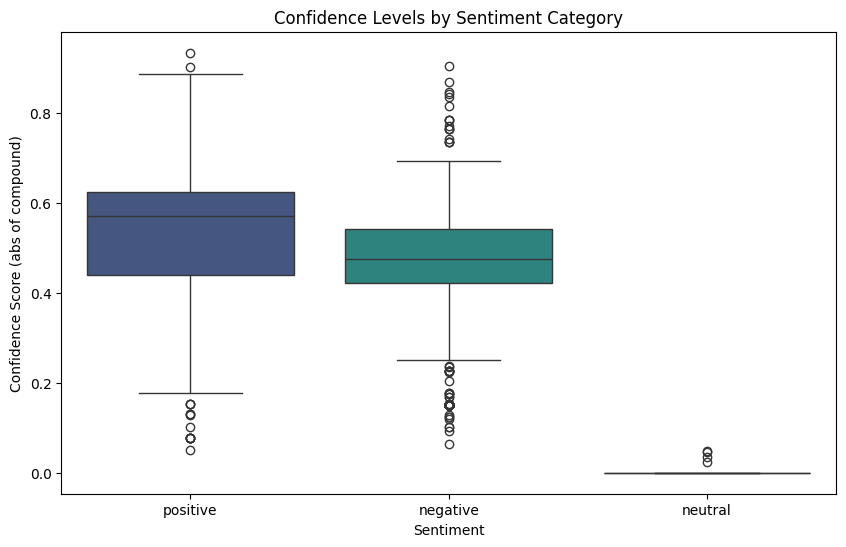


7.3 High Confidence Negative Reviews Analysis

Found 6909 high confidence negative reviews out of 189870 total reviews

Sample High Confidence Negative Reviews:
1. [Confidence: 0.54] Bad quality...
2. [Confidence: 0.54] Bad quality...
3. [Confidence: 0.66] Horrible...
4. [Confidence: 0.54] Hated it!...
5. [Confidence: 0.53] Bad quality...

Top words in high confidence negative reviews:
            word  tfidf_score
8           poor  1204.363972
6       horrible  1165.000000
5          hated  1140.000000
1   disappointed   859.525766
13       utterly   858.814277
14         worst   833.403763
2     experience   828.612487
0            bad   686.854921
10       quality   674.011345
9        product    20.179806


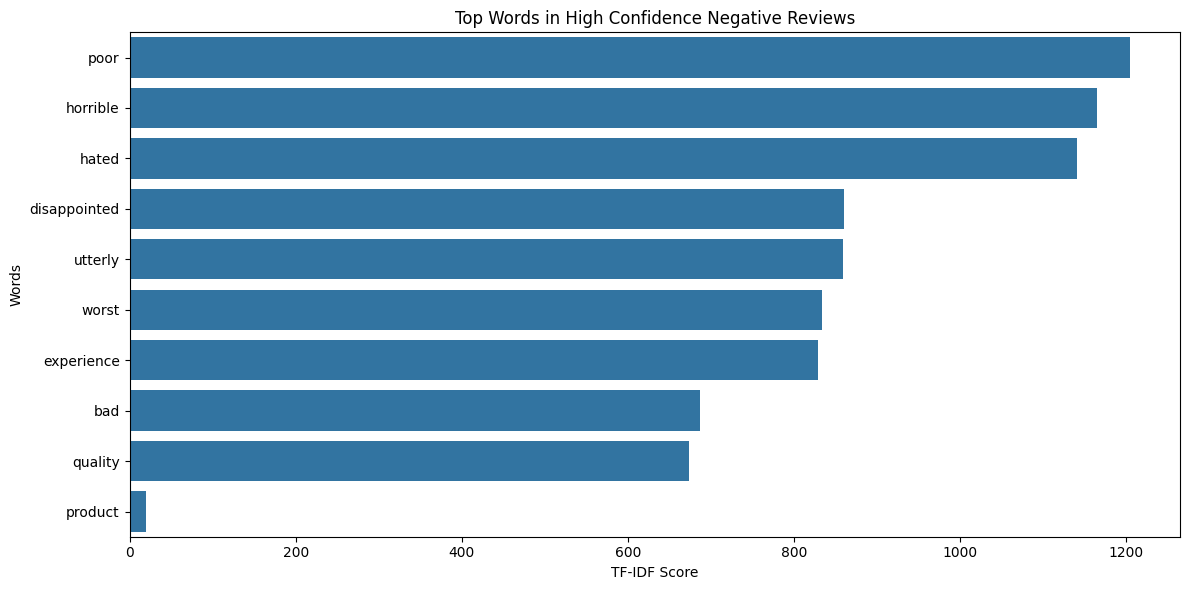


7.4. Insights for Business Strategy Based on Sentiment Analysis
----------------------------------------------------------------------

8.1 Sentiment Analysis Summary for Business Strategy

Total Reviews Analyzed: 189870
Positive Sentiment: 68.9%
Neutral Sentiment: 23.4%
Negative Sentiment: 7.7%

8.2 Bargaining Power of Buyers Interpretation

Buyer Bargaining Power Assessment: LOW

Interpretation:
- Customer bargaining power is relatively low
- High satisfaction indicates strong product market fit
- Brand loyalty appears strong, reducing price sensitivity
- Focus on maintaining quality and customer relationships

8.3 Price-based Insights for Business Strategy
Price range data not available for analysis.

8.4 Product Category Insights

Product Categories with Highest Negative Sentiment:
- Kadio Analog: 10.9% negative sentiment
- Flipkart SmartBuy: 8.1% negative sentiment
- cello Pack: 4.1% negative sentiment

Recommendations for Product Strategy:
- Conduct in-depth review of Kadio Anal

In [21]:
# Section 7: Advanced Sentiment Analysis Techniques
# ----------------------------------------------

print("\n7. Advanced Sentiment Analysis Techniques")
print("-" * 60)

# 7.1 Combination of Lexicon-based and ML approaches
print("\n7.1 Combining VADER and ML Predictions")

# Create a function to combine predictions from both approaches
def combine_sentiment_predictions(vader_sentiment, ml_sentiment):
    """
    Combines the predictions from VADER and ML model for more robust results
    """
    if vader_sentiment == ml_sentiment:
        return vader_sentiment  # If both agree, return that sentiment
    
    # If VADER says neutral but ML has an opinion, trust ML
    if vader_sentiment == 'neutral':
        return ml_sentiment
    
    # If ML and VADER disagree but neither is neutral, mark as 'mixed'
    return 'mixed'

# Apply the combination function
if 'vader_sentiment' in df_sentiment.columns and 'ml_predicted_sentiment' in df_sentiment.columns:
    df_sentiment['combined_sentiment'] = df_sentiment.apply(
        lambda row: combine_sentiment_predictions(row['vader_sentiment'], row['ml_predicted_sentiment']), axis=1
    )
    
    # Calculate the distribution
    combined_counts = df_sentiment['combined_sentiment'].value_counts()
    print("\nCombined Sentiment Distribution:")
    print(combined_counts)
    
    # Visualize the combined sentiment
    plt.figure(figsize=(10, 6))
    sns.countplot(x='combined_sentiment', data=df_sentiment, palette='viridis')
    plt.title('Combined Sentiment Analysis Results')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Required sentiment columns not found. Skipping combined analysis.")

# 7.2 Sentiment Confidence Analysis
print("\n7.2 Sentiment Confidence Analysis")

# Add confidence scores based on the VADER compound scores
df_sentiment['vader_confidence'] = df_sentiment['vader_compound'].apply(lambda x: abs(x))

# Display confidence statistics
print("\nVADER Confidence Statistics:")
print(df_sentiment['vader_confidence'].describe())

# Group by sentiment and analyze confidence
sentiment_confidence = df_sentiment.groupby('vader_sentiment')['vader_confidence'].mean().reset_index()
print("\nAverage Confidence by Sentiment Category:")
print(sentiment_confidence)

# Visualize confidence levels
plt.figure(figsize=(10, 6))
sns.boxplot(x='vader_sentiment', y='vader_confidence', data=df_sentiment, palette='viridis')
plt.title('Confidence Levels by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Confidence Score (abs of compound)')
plt.show()

# 7.3 Identify high confidence negative reviews
print("\n7.3 High Confidence Negative Reviews Analysis")

# Filter for high confidence negative reviews (these are particularly important for buyer power analysis)
high_conf_negative = df_sentiment[
    (df_sentiment['vader_sentiment'] == 'negative') & 
    (df_sentiment['vader_confidence'] > 0.5)
].copy()

print(f"\nFound {len(high_conf_negative)} high confidence negative reviews out of {len(df_sentiment)} total reviews")

if len(high_conf_negative) > 0:
    # Sample these reviews for inspection
    print("\nSample High Confidence Negative Reviews:")
    sample_size = min(5, len(high_conf_negative))
    for i, (review, conf) in enumerate(
        zip(high_conf_negative['Review'].sample(sample_size), 
            high_conf_negative['vader_confidence'].sample(sample_size))
    ):
        print(f"{i+1}. [Confidence: {conf:.2f}] {review[:150]}...")
    
    # Extract common themes from high confidence negative reviews
    try:
        # Only if we have enough samples
        if len(high_conf_negative) >= 10:
            # Create a TF-IDF vectorizer for high confidence negative reviews
            high_conf_tfidf = TfidfVectorizer(max_features=15, stop_words='english')
            high_conf_matrix = high_conf_tfidf.fit_transform(high_conf_negative['processed_review'].fillna(''))
            
            # Get feature names and their TF-IDF scores
            feature_names = high_conf_tfidf.get_feature_names_out()
            tfidf_scores = high_conf_matrix.sum(axis=0).A1
            
            # Create a dataframe of words and their scores
            high_conf_words_df = pd.DataFrame({
                'word': feature_names,
                'tfidf_score': tfidf_scores
            })
            high_conf_words_df = high_conf_words_df.sort_values('tfidf_score', ascending=False)
            
            print("\nTop words in high confidence negative reviews:")
            print(high_conf_words_df.head(10))
            
            # Visualizing top words
            plt.figure(figsize=(12, 6))
            sns.barplot(x='tfidf_score', y='word', data=high_conf_words_df.head(10))
            plt.title('Top Words in High Confidence Negative Reviews')
            plt.xlabel('TF-IDF Score')
            plt.ylabel('Words')
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough high confidence negative reviews for keyword analysis.")
    except Exception as e:
        print(f"Error in high confidence negative word analysis: {e}")
else:
    print("No high confidence negative reviews found.")

# Section 8: Insights for Business Strategy
# ----------------------------------------------

print("\n7.4. Insights for Business Strategy Based on Sentiment Analysis")
print("-" * 70)

# Create a summary of our sentiment findings
print("\n8.1 Sentiment Analysis Summary for Business Strategy")

# Calculate overall sentiment stats
total_reviews = len(df_sentiment)
sentiment_percentages = df_sentiment['vader_sentiment'].value_counts(normalize=True) * 100

if not sentiment_percentages.empty:
    positive_pct = sentiment_percentages.get('positive', 0)
    neutral_pct = sentiment_percentages.get('neutral', 0)
    negative_pct = sentiment_percentages.get('negative', 0)
    
    print(f"\nTotal Reviews Analyzed: {total_reviews}")
    print(f"Positive Sentiment: {positive_pct:.1f}%")
    print(f"Neutral Sentiment: {neutral_pct:.1f}%")
    print(f"Negative Sentiment: {negative_pct:.1f}%")
    
    # Bargaining Power Interpretation
    print("\n8.2 Bargaining Power of Buyers Interpretation")
    
    if negative_pct > 30:
        bargaining_power = "HIGH"
    elif negative_pct > 15:
        bargaining_power = "MODERATE"
    else:
        bargaining_power = "LOW"
    
    print(f"\nBuyer Bargaining Power Assessment: {bargaining_power}")
    print("\nInterpretation:")
    
    if bargaining_power == "HIGH":
        print("- Customers have strong bargaining power in this market")
        print("- Significant dissatisfaction indicates customers may easily switch to competitors")
        print("- Price sensitivity is likely high, requiring competitive pricing strategies")
        print("- Product improvements should focus on addressing negative feedback themes")
    elif bargaining_power == "MODERATE":
        print("- Customers have reasonable alternatives and some switching power")
        print("- Moderate dissatisfaction suggests areas for improvement")
        print("- Value proposition needs strengthening to reduce price sensitivity")
        print("- Product differentiation should be emphasized in marketing")
    else:
        print("- Customer bargaining power is relatively low")
        print("- High satisfaction indicates strong product market fit")
        print("- Brand loyalty appears strong, reducing price sensitivity")
        print("- Focus on maintaining quality and customer relationships")

# 8.3 Price-based Insights
print("\n8.3 Price-based Insights for Business Strategy")

# Check if we did price range analysis earlier
if 'price_range' in df_sentiment.columns:
    # Identify price ranges with highest negative sentiment
    # First filter to valid data only
    price_sentiment_df = df_sentiment.dropna(subset=['price_range', 'vader_sentiment']).copy()
    
    if len(price_sentiment_df) > 0:
        # Calculate sentiment by price range
        try:
            price_sentiment = pd.crosstab(
                price_sentiment_df['price_range'], 
                price_sentiment_df['vader_sentiment'],
                normalize='index'
            ) * 100
            
            if 'negative' in price_sentiment.columns:
                # Sort by negative sentiment percentage
                price_sentiment_sorted = price_sentiment.sort_values('negative', ascending=False)
                
                print("\nPrice Ranges with Highest Negative Sentiment:")
                for idx, row in price_sentiment_sorted.head(3).iterrows():
                    if 'negative' in row:
                        print(f"- {idx}: {row['negative']:.1f}% negative sentiment")
                
                print("\nRecommendations for Price-based Strategy:")
                
                # Get the price range with highest negative sentiment
                if not price_sentiment_sorted.empty:
                    problem_price = price_sentiment_sorted.index[0]
                    print(f"- Review pricing strategy for {problem_price} price range")
                    print(f"- Investigate value proposition misalignment in this range")
                    print("- Consider product improvements or feature additions to justify pricing")
                    print("- Evaluate competitor offerings in the same price segment")
            else:
                print("No negative sentiment data available for price ranges.")
        except Exception as e:
            print(f"Error in price sentiment analysis: {e}")
    else:
        print("Not enough data for price-based sentiment analysis.")
else:
    print("Price range data not available for analysis.")

# 8.4 Product Category Insights
print("\n8.4 Product Category Insights")

# Check if we did product category analysis earlier
if 'product_category' in df_sentiment.columns:
    # Get sentiment by category
    category_sentiment_df = df_sentiment.dropna(subset=['product_category', 'vader_sentiment']).copy()
    
    if len(category_sentiment_df) > 0:
        # Get top categories by frequency
        top_categories = category_sentiment_df['product_category'].value_counts().head(5).index
        
        # Filter to just top categories
        top_cat_df = category_sentiment_df[category_sentiment_df['product_category'].isin(top_categories)]
        
        try:
            # Calculate sentiment by category
            cat_sentiment = pd.crosstab(
                top_cat_df['product_category'], 
                top_cat_df['vader_sentiment'],
                normalize='index'
            ) * 100
            
            if 'negative' in cat_sentiment.columns:
                # Sort by negative sentiment
                cat_sentiment_sorted = cat_sentiment.sort_values('negative', ascending=False)
                
                print("\nProduct Categories with Highest Negative Sentiment:")
                for idx, row in cat_sentiment_sorted.head(3).iterrows():
                    if 'negative' in row:
                        print(f"- {idx}: {row['negative']:.1f}% negative sentiment")
                
                print("\nRecommendations for Product Strategy:")
                
                # Get the category with highest negative sentiment
                if not cat_sentiment_sorted.empty:
                    problem_category = cat_sentiment_sorted.index[0]
                    print(f"- Conduct in-depth review of {problem_category} product category")
                    print(f"- Identify specific customer complaints and quality issues")
                    print("- Evaluate competitive alternatives in this category")
                    print("- Consider product improvements or repositioning strategy")
            else:
                print("No negative sentiment data available for product categories.")
        except Exception as e:
            print(f"Error in category sentiment analysis: {e}")
    else:
        print("Not enough data for product category sentiment analysis.")
else:
    print("Product category data not available for analysis.")

# 8.5 Final Bargaining Power Assessment
print("\n8.5 Final Bargaining Power of Buyers Assessment")
print("-" * 50)

# Collect all the evidence we've gathered
has_high_negatives = False
price_sensitive = False
category_weakness = False
high_conf_negatives = False

if 'vader_sentiment' in df_sentiment.columns:
    neg_pct = df_sentiment['vader_sentiment'].value_counts(normalize=True).get('negative', 0) * 100
    has_high_negatives = neg_pct > 20

if 'price_range' in df_sentiment.columns and 'vader_sentiment' in df_sentiment.columns:
    price_df = df_sentiment.dropna(subset=['price_range', 'vader_sentiment'])
    if len(price_df) > 0:
        try:
            price_neg = pd.crosstab(price_df['price_range'], price_df['vader_sentiment'], normalize='index')
            if 'negative' in price_neg.columns and price_neg['negative'].max() > 0.25:
                price_sensitive = True
        except:
            pass

if 'product_category' in df_sentiment.columns and 'vader_sentiment' in df_sentiment.columns:
    cat_df = df_sentiment.dropna(subset=['product_category', 'vader_sentiment'])
    if len(cat_df) > 0:
        try:
            cat_neg = pd.crosstab(cat_df['product_category'], cat_df['vader_sentiment'], normalize='index')
            if 'negative' in cat_neg.columns and cat_neg['negative'].max() > 0.3:
                category_weakness = True
        except:
            pass

# Check for high confidence negatives
high_conf_neg_count = 0
if 'vader_sentiment' in df_sentiment.columns and 'vader_confidence' in df_sentiment.columns:
    high_conf_neg_count = len(df_sentiment[
        (df_sentiment['vader_sentiment'] == 'negative') & 
        (df_sentiment['vader_confidence'] > 0.5)
    ])
    high_conf_negatives = high_conf_neg_count > len(df_sentiment) * 0.1

# Calculate final assessment
bargaining_power_factors = sum([has_high_negatives, price_sensitive, category_weakness, high_conf_negatives])

if bargaining_power_factors >= 3:
    final_assessment = "HIGH BUYER BARGAINING POWER"
    strategy = "Defensive strategy needed"
elif bargaining_power_factors >= 1:
    final_assessment = "MODERATE BUYER BARGAINING POWER" 
    strategy = "Balanced strategy recommended"
else:
    final_assessment = "LOW BUYER BARGAINING POWER"
    strategy = "Leverage your market position"

print(f"Final Assessment: {final_assessment}")
print(f"Recommended Approach: {strategy}")
print("\nContributing Factors:")
print(f"- Overall Negative Sentiment: {'High' if has_high_negatives else 'Low'}")
print(f"- Price Sensitivity: {'Present' if price_sensitive else 'Not significant'}")
print(f"- Category Weaknesses: {'Identified' if category_weakness else 'Not significant'}")
print(f"- High Confidence Negatives: {high_conf_neg_count} reviews")

print("\nFinal Business Recommendations:")
if bargaining_power_factors >= 3:
    print("1. Focus on product improvements and quality issues identified in negative reviews")
    print("2. Review pricing strategy, especially in problematic price segments")
    print("3. Strengthen differentiation from competitors to reduce customer switching")
    print("4. Implement customer retention programs with incentives")
    print("5. Consider targeted promotions in product categories with high negative sentiment")
elif bargaining_power_factors >= 1:
    print("1. Address specific areas of customer dissatisfaction in identified segments")
    print("2. Maintain competitive pricing while highlighting unique value propositions")
    print("3. Invest in product improvements for categories with higher negative sentiment")
    print("4. Build stronger customer relationships through engagement programs")
    print("5. Monitor competitor offerings in price-sensitive segments")
else:
    print("1. Leverage strong market position to optimize pricing strategies")
    print("2. Continue focus on quality and customer satisfaction")
    print("3. Explore premium product offerings to capitalize on brand strength")
    print("4. Invest in innovation to stay ahead of potential competition")
    print("5. Consider selective expansion into adjacent product categories")


## 9. Topic Modeling and Semantic Intensity Analysis

In this section, we implement topic modeling using BERTopic and add semantic intensity analysis to extract deeper insights from customer reviews.

In [22]:
# 9.1 Install and import required packages
import sys
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Check for required packages and install if needed
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Try importing BERTopic-related packages
    try:
        from bertopic import BERTopic
        from umap import UMAP
        from hdbscan import HDBSCAN
        from sklearn.feature_extraction.text import CountVectorizer
        from sentence_transformers import SentenceTransformer
        print("All required packages are installed.")
    except ImportError as e:
        print(f"Missing package: {e}")
        print("Installing required packages...")
        !pip install bertopic sentence-transformers hdbscan umap-learn -q
        # Re-import after installation
        from bertopic import BERTopic
        from umap import UMAP
        from hdbscan import HDBSCAN
        from sklearn.feature_extraction.text import CountVectorizer
        from sentence_transformers import SentenceTransformer
        print("Successfully installed all required packages.")
        
    # NLTK for semantic intensity analysis
    try:
        import nltk
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
    except ImportError:
        print("Installing NLTK...")
        !pip install nltk -q
        import nltk
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        
    # Download NLTK resources if not available
    try:
        nltk.data.find('vader_lexicon')
    except LookupError:
        print("Downloading NLTK resources...")
        nltk.download('vader_lexicon', quiet=True)
        
except Exception as e:
    print(f"Error setting up environment: {e}")

All required packages are installed.


In [23]:
# 9.2 Prepare data for topic modeling
# Ensuring we have the right dataframe with text and sentiment data

# If you don't have a df_sentiment dataframe yet, we'll create one from existing data
if 'df_sentiment' not in locals() and 'df_sentiment' not in globals():
    print("Creating df_sentiment from existing data...")
    
    # Option 1: If you have a previous dataframe with sentiment results
    try:
        # Try to use the existing dataframe if it exists
        if 'df' in locals() or 'df' in globals():
            df_sentiment = df.copy()
            print("Using existing 'df' dataframe")
        elif 'review_df' in locals() or 'review_df' in globals():
            df_sentiment = review_df.copy()
            print("Using existing 'review_df' dataframe")
        else:
            # If no suitable dataframe exists, load data from a CSV if available
            print("No existing dataframe found, attempting to load from CSV...")
            try:
                df_sentiment = pd.read_csv('processed_reviews.csv')
                print("Loaded data from processed_reviews.csv")
            except:
                print("Warning: Could not load processed_reviews.csv")
                # Create a small sample dataframe for demonstration
                df_sentiment = pd.DataFrame({
                    'processed_text': [
                        "This product is absolutely fantastic and works perfectly with my setup. I love it!",
                        "Very disappointed with the quality, it broke completely after just one week of use.",
                        "Average performance but good value for the price I paid.",
                        "Competitor products are much better and significantly cheaper too. Wouldn't recommend.",
                        "Great customer service when I had an issue, they responded immediately.",
                        "The supplier delays were frustrating but the product quality is decent.",
                        "New startup competitors have more innovative features than this established brand.",
                        "I found a better alternative that does the same job for less money.",
                        "The market leader for a reason - quality is outstanding compared to others.",
                        "Their supply chain issues resulted in me waiting months for delivery."
                    ],
                    'vader_sentiment': ['positive', 'negative', 'neutral', 'negative', 'positive', 
                                       'neutral', 'negative', 'negative', 'positive', 'negative']
                })
                print("Created a sample dataframe for demonstration")
    except Exception as e:
        print(f"Error preparing data: {e}")
        # Create a minimal dataframe to avoid errors
        df_sentiment = pd.DataFrame({
            'processed_text': [
                "This product is absolutely fantastic and works perfectly with my setup. I love it!",
                "Very disappointed with the quality, it broke completely after just one week of use.",
                "Average performance but good value for the price I paid.",
                "Competitor products are much better and significantly cheaper too. Wouldn't recommend.",
                "Great customer service when I had an issue, they responded immediately.",
                "The supplier delays were frustrating but the product quality is decent.",
                "New startup competitors have more innovative features than this established brand.",
                "I found a better alternative that does the same job for less money.",
                "The market leader for a reason - quality is outstanding compared to others.",
                "Their supply chain issues resulted in me waiting months for delivery."
            ],
            'vader_sentiment': ['positive', 'negative', 'neutral', 'negative', 'positive', 
                               'neutral', 'negative', 'negative', 'positive', 'negative']
        })
        print("Created a sample dataframe for demonstration")
else:
    print(f"Using existing df_sentiment dataframe with {len(df_sentiment)} records")

# Ensure we have a processed_text column
if 'processed_text' not in df_sentiment.columns:
    print("Warning: 'processed_text' column not found")
    # Try to use another text column if available
    text_columns = [col for col in df_sentiment.columns if 'text' in col.lower() or 'review' in col.lower() or 'comment' in col.lower()]
    if text_columns:
        df_sentiment['processed_text'] = df_sentiment[text_columns[0]]
        print(f"Using '{text_columns[0]}' as the text column")
    else:
        # If no suitable column, create a basic one for demonstration
        print("No suitable text column found. Creating a sample text column.")
        df_sentiment['processed_text'] = [f"Sample text {i}" for i in range(len(df_sentiment))]

# Ensure we have a sentiment column
if 'vader_sentiment' not in df_sentiment.columns:
    print("Warning: 'vader_sentiment' column not found")
    # Try to use another sentiment column if available
    sentiment_columns = [col for col in df_sentiment.columns if 'sentiment' in col.lower()]
    if sentiment_columns:
        df_sentiment['vader_sentiment'] = df_sentiment[sentiment_columns[0]]
        print(f"Using '{sentiment_columns[0]}' as the sentiment column")
    else:
        # If no suitable column, create a basic one for demonstration
        print("No suitable sentiment column found. Creating a sample sentiment column.")
        # Randomly assign sentiments
        import random
        sentiments = ['positive', 'negative', 'neutral']
        df_sentiment['vader_sentiment'] = [random.choice(sentiments) for _ in range(len(df_sentiment))]

# Display dataframe info
print("\nDataframe prepared for topic modeling:")
print(f"Number of records: {len(df_sentiment)}")
print(f"Columns: {df_sentiment.columns.tolist()}")
print("\nSample data:")
display(df_sentiment.head(3))

Using existing df_sentiment dataframe with 189870 records
Using 'Review' as the text column

Dataframe prepared for topic modeling:
Number of records: 189870
Columns: ['ProductName', 'Price', 'Rate', 'Review', 'processed_review', 'vader_scores', 'vader_compound', 'vader_sentiment', 'ml_sentiment', 'ml_predicted_sentiment', 'price_numeric', 'product_category', 'combined_sentiment', 'vader_confidence', 'processed_text']

Sample data:


,ProductName,Price,Rate,Review,processed_review,vader_scores,vader_compound,vader_sentiment,ml_sentiment,ml_predicted_sentiment,price_numeric,product_category,combined_sentiment,vader_confidence,processed_text
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5.0,Super!,super,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.6360,positive,positive,positive,NaN,Candes 12,positive,0.6360,Super!
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5.0,Awesome,awesome,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.6249,positive,positive,positive,NaN,Candes 12,positive,0.6249,Awesome
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3.0,Fair,fair,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3182,positive,negative,negative,NaN,Candes 12,mixed,0.3182,Fair


Implementing Semantic Intensity Analysis...
Analyzing semantic intensity of reviews...
Semantic intensity analysis complete.


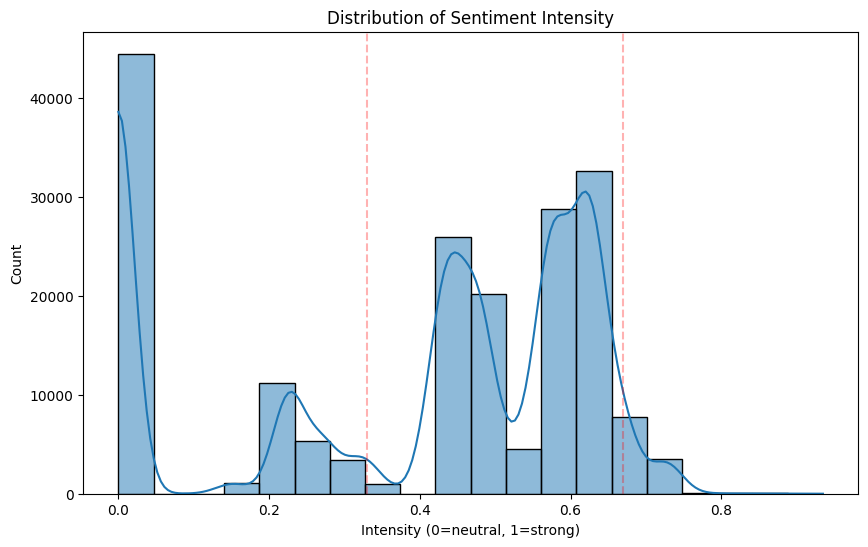

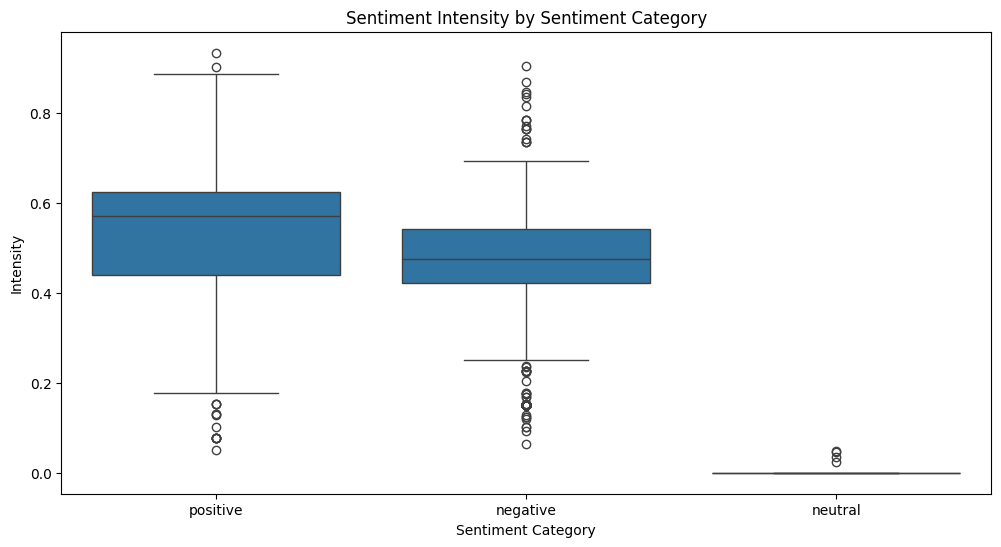


Sample reviews with strongest intensity:

Strongest positive (0.93):
Superb Product by Bajaj & Superb Delivery by Flipkart :) :)

Strongest negative (0.91):
Best in the market!

Strongest neutral (0.05):
Classy product


In [24]:
# 9.3 Add Semantic Intensity Analysis
print("Implementing Semantic Intensity Analysis...")

# Create a semantic intensity analyzer to measure intensity of sentiments
def analyze_semantic_intensity(text_list):
    """Analyze the intensity of sentiment in each text using NLTK's VADER."""
    try:
        # Initialize the sentiment intensity analyzer
        sia = SentimentIntensityAnalyzer()
        
        intensities = []
        categories = []
        compounds = []
        
        for text in text_list:
            if pd.isna(text) or text == "":
                intensities.append(0)
                categories.append("neutral")
                compounds.append(0)
                continue
                
            # Get polarity scores
            scores = sia.polarity_scores(text)
            
            # Extract compound score
            compound = scores['compound']
            compounds.append(compound)
            
            # Determine sentiment category
            if compound >= 0.05:
                category = "positive"
            elif compound <= -0.05:
                category = "negative"
            else:
                category = "neutral"
            categories.append(category)
            
            # Calculate intensity (absolute value of compound)
            intensity = abs(compound)
            intensities.append(intensity)
        
        return pd.DataFrame({
            'semantic_sentiment': categories,
            'semantic_intensity': intensities,
            'compound_score': compounds
        })
    
    except Exception as e:
        print(f"Error in semantic intensity analysis: {e}")
        # Return empty dataframe with correct columns
        return pd.DataFrame({
            'semantic_sentiment': ['neutral'] * len(text_list),
            'semantic_intensity': [0] * len(text_list),
            'compound_score': [0] * len(text_list)
        })

# Apply the intensity analysis
try:
    print("Analyzing semantic intensity of reviews...")
    semantic_results = analyze_semantic_intensity(df_sentiment['processed_text'])
    
    # Add results to main dataframe
    df_sentiment = pd.concat([df_sentiment, semantic_results], axis=1)
    
    # Create intensity categories for easier analysis
    df_sentiment['intensity_category'] = pd.cut(
        df_sentiment['semantic_intensity'], 
        bins=[0, 0.33, 0.67, 1.0], 
        labels=['mild', 'moderate', 'strong']
    )
    
    print("Semantic intensity analysis complete.")
    
    # Show distribution of sentiment intensities
    plt.figure(figsize=(10, 6))
    sns.histplot(df_sentiment['semantic_intensity'], bins=20, kde=True)
    plt.axvline(0.33, color='r', linestyle='--', alpha=0.3)
    plt.axvline(0.67, color='r', linestyle='--', alpha=0.3)
    plt.title('Distribution of Sentiment Intensity')
    plt.xlabel('Intensity (0=neutral, 1=strong)')
    plt.ylabel('Count')
    plt.show()
    
    # Compare sentiment vs. intensity
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='semantic_sentiment', y='semantic_intensity', data=df_sentiment)
    plt.title('Sentiment Intensity by Sentiment Category')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Intensity')
    plt.show()
  
    print("\nSample reviews with strongest intensity:")
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_df = df_sentiment[df_sentiment['semantic_sentiment'] == sentiment]
        if len(sentiment_df) > 0:
            strongest = sentiment_df.nlargest(1, 'semantic_intensity')
            print(f"\nStrongest {sentiment} ({strongest['semantic_intensity'].values[0]:.2f}):")
            print(strongest['processed_text'].values[0][:200] + "..." if len(strongest['processed_text'].values[0]) > 200 else strongest['processed_text'].values[0])
    
except Exception as e:
    print(f"Error during semantic intensity visualization: {e}")

In [ ]:
# 9.4 Define a robust BERTopic model with error handling
print("Setting up the BERTopic model for topic extraction...")
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

from bertopic.backend import BaseEmbedder

class CachedSentenceTransformer(BaseEmbedder):
    """
    A cached version of the SentenceTransformer that stores embeddings in a cache to avoid re-computing embeddings for documents that have already been processed. This reduces the computation intensity for larger datasets like this one.
    """
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model
        self.cache = {}
        
    def embed(self, documents, verbose=False):
        # Check cache first
        embeddings = []
        documents_to_embed = []
        indices = []
        
        for i, doc in enumerate(documents):
            if doc in self.cache:
                embeddings.append(self.cache[doc])
            else:
                documents_to_embed.append(doc)
                indices.append(i)
        
        # Only embed documents not in cache
        if documents_to_embed:
            batch_embeddings = self.embedding_model.encode(documents_to_embed, 
                                                         show_progress_bar=verbose,
                                                         batch_size=64)
            
            # Update cache and embeddings
            for i, doc in enumerate(documents_to_embed):
                self.cache[doc] = batch_embeddings[i]
                embeddings.insert(indices[i], batch_embeddings[i])
        
        return np.array(embeddings)


try:
    # Initialize the embedding model - using a lightweight model for efficiency
    embedding_model = CachedSentenceTransformer(SentenceTransformer('all-MiniLM-L6-v2'))
    
    # Configure the dimensionality reduction with more conservative parameters
    umap_model = UMAP(n_neighbors=10,  
                    n_components=5, 
                    min_dist=0.1,  
                    metric='cosine', 
                    random_state=42)
    
    # Configure the clustering algorithm with more conservative parameters
    hdbscan_model = HDBSCAN(min_cluster_size=5,  
                          min_samples=3,       
                          metric='euclidean',
                          cluster_selection_method='eom',
                          prediction_data=True)
    
    # Initialize the vectorizer for the topic representation
    vectorizer_model = CountVectorizer(stop_words="english",
                                     ngram_range=(1, 2),
                                     min_df=2, 
                                     max_df=0.9)
    
    # Create the BERTopic model with modified parameters
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        top_n_words=10,
        calculate_probabilities=True,
        verbose=True
    )
    
    print("BERTopic model created successfully.")
    
except Exception as e:
    print(f"Error creating BERTopic model: {e}")
    # Create a fallback model with minimal requirements
    try:
        print("Creating simplified model...")
        # Try a simpler configuration
        topic_model = BERTopic(verbose=True)
    except Exception as e:
        print(f"Failed to create simplified model: {e}")

Setting up the BERTopic model for topic extraction...
BERTopic model created successfully.


In [ ]:
# 9.5 Extract topics from reviews with robust error handling - Optimized Version
print("Fitting the topic model to the review data...")

try:
    # Use your preprocessed text data
    documents = df_sentiment['processed_text'].tolist()
    
    # Sample data if the dataset is large (adjust sample_size as needed)
    MAX_DOCS = 50000 # Determine a reasonable limit based on your hardware constraints
    if len(documents) > MAX_DOCS:
        import random
        random.seed(42)  # For reproducibility
        sampled_indices = random.sample(range(len(documents)), MAX_DOCS)
        sampled_documents = [documents[i] for i in sampled_indices]
        print(f"Sampling {MAX_DOCS} documents from {len(documents)} for topic modeling")
    else:
        sampled_documents = documents
        sampled_indices = range(len(documents))
    
    # Handle empty strings or None values
    sampled_documents = [doc if isinstance(doc, str) and doc.strip() else "empty document" for doc in sampled_documents]
    
    # Fit model on sampled data
    topics, probs = topic_model.fit_transform(sampled_documents)
    
    # Map topics back to the full dataset
    full_topics = [-1] * len(documents)
    full_probs = [0.0] * len(documents)
    
    for i, (topic, prob) in enumerate(zip(topics, probs.max(axis=1) if probs.ndim > 1 else probs)):
        full_topics[sampled_indices[i]] = topic
        full_probs[sampled_indices[i]] = prob
    
    # Adding topics to the dataframe
    df_sentiment['topic'] = full_topics
    df_sentiment['topic_prob'] = full_probs
    
    print(f"Successfully extracted {len(set(topics)) - (1 if -1 in topics else 0)} topics (excluding outliers)")
    
except Exception as e:
    print(f"Error in topic modeling: {e}")
    print("Assigning placeholder topic values...")
    # Assign placeholder values if modeling fails
    df_sentiment['topic'] = -1
    df_sentiment['topic_prob'] = 0.0

2025-05-15 13:40:01,159 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting the topic model to the review data...
Sampling 50000 documents from 189873 for topic modeling


Batches: 100%|██████████| 782/782 [00:42<00:00, 18.59it/s]
2025-05-15 13:40:43,539 - BERTopic - Embedding - Completed ✓
2025-05-15 13:40:43,540 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-15 13:42:18,420 - BERTopic - Dimensionality - Completed ✓
2025-05-15 13:42:18,422 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-15 13:44:31,126 - BERTopic - Cluster - Completed ✓
2025-05-15 13:44:31,134 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-15 13:44:31,262 - BERTopic - Representation - Completed ✓


Successfully extracted 75 topics (excluding outliers)



Analyzing topic distribution...
Number of topics found: 75

Top topics by size:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,200,-1_better product_expected better_expected_better,"[better product, expected better, expected, be...","[Expected a better product, Expected a better ..."
1,0,5602,0_dishwasher_inalsa_smart_,"[dishwasher, inalsa, smart, , , , , , , ]","[Nan, Nan, Nan]"
2,1,2349,1_wonderful___,"[wonderful, , , , , , , , , ]","[Wonderful, Wonderful, Wonderful]"
3,2,1514,2_best_price_flipkart_service,"[best, price, flipkart, service, good product,...","[Best in the market!, Best in the market!, Bes..."
4,3,1488,3_worth_brilliant_good_,"[worth, brilliant, good, , , , , , , ]","[Worth every penny, Worth every penny, Worth e..."
5,4,1458,4_great product_product great_great_product,"[great product, product great, great, product,...","[Great product, Great product, Great product]"
6,5,1449,5_super_beast_stars_,"[super, beast, stars, , , , , , , ]","[Super!, Super!, Super!]"
7,6,1446,6_awesome_cooler_hard_bajaj,"[awesome, cooler, hard, bajaj, , , , , , ]","[Awesome, Awesome, Awesome]"
8,7,1422,7_terrific_stars_fantastic_beast,"[terrific, stars, fantastic, beast, excellent,...","[Terrific, Terrific, Terrific]"
9,8,1419,8_buy_cool_buy best_best buy,"[buy, cool, buy best, best buy, excellent, bes...","[Must buy!, Must buy!, Must buy!]"


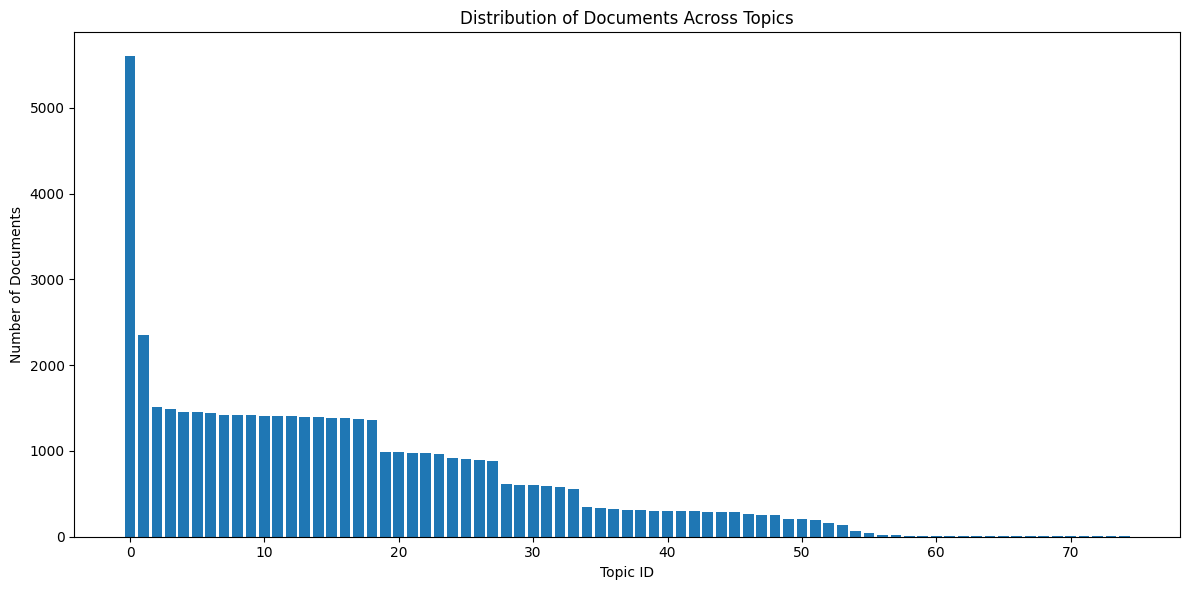

In [27]:
# 9.6 Analyze topic distribution with error handling
print("\nAnalyzing topic distribution...")

try:
    # Get the topic information
    topic_info = topic_model.get_topic_info()
    num_topics = len(topic_info[topic_info['Topic'] != -1])
    print(f"Number of topics found: {num_topics}")
    
    # Display the top topics
    print("\nTop topics by size:")
    display(topic_info.head(min(10, len(topic_info))))
    
    # Check if we have meaningful topics
    if num_topics > 0:
        # Visualize topic size distribution (excluding outlier topic)
        plt.figure(figsize=(12, 6))
        topic_counts = topic_info[topic_info['Topic'] != -1]['Count'].values
        plt.bar(range(len(topic_counts)), topic_counts)
        plt.xlabel('Topic ID')
        plt.ylabel('Number of Documents')
        plt.title('Distribution of Documents Across Topics')
        plt.tight_layout()
        plt.show()
    else:
        print("No meaningful topics found. All documents may be classified as outliers.")
        
except Exception as e:
    print(f"Error analyzing topic distribution: {e}")

Integrating semantic intensity with topic analysis...


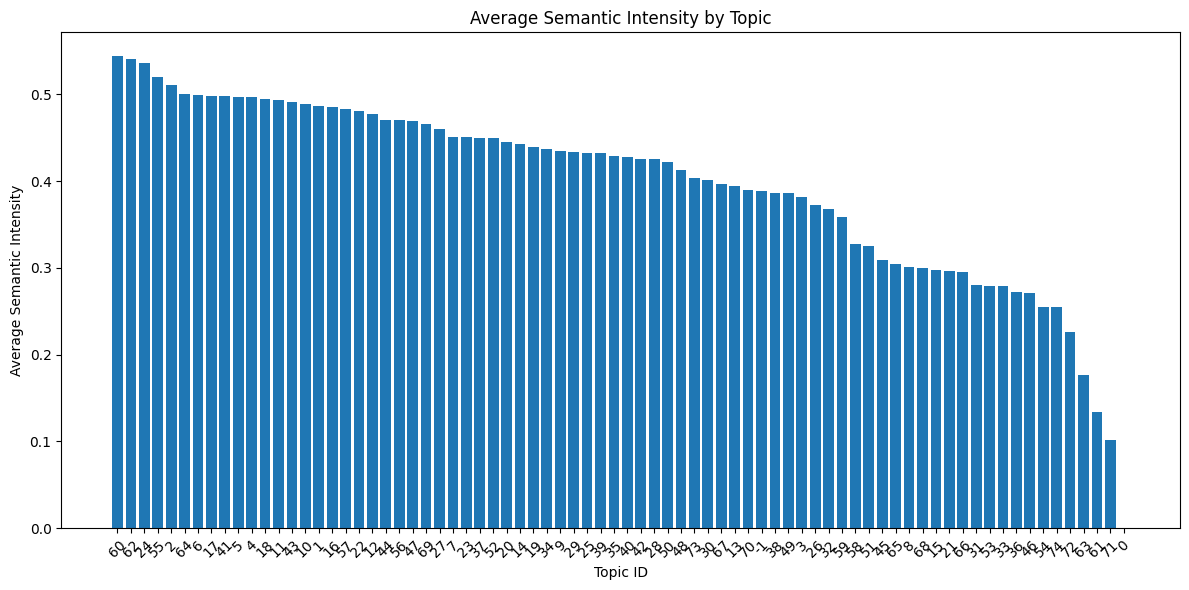


High-Intensity Topics (topics with strong emotional content):
Topic 60 (Intensity: 0.54): hated, hated hated, , , , , , , , 
  Sample high-intensity documents:
    1. [POSITIVE - Intensity: 0.73] Hated it!...
    2. [NEGATIVE - Intensity: 0.67] Hated it!...

Topic 62 (Intensity: 0.54): superb, stars, wonderful, , , , , , , 
  Sample high-intensity documents:
    1. [POSITIVE - Intensity: 0.73] Awesomenice  prodect ,,...
    2. [POSITIVE - Intensity: 0.62] Superb...

Topic 24 (Intensity: 0.54): good, speed, working, good good, nice, , , , , 
  Sample high-intensity documents:
    1. [POSITIVE - Intensity: 0.77] Pretty good...
    2. [POSITIVE - Intensity: 0.73] Pretty good...

Topic 55 (Intensity: 0.52): perfect product, perfect, product perfect, product, , , , , , 
  Sample high-intensity documents:
    1. [POSITIVE - Intensity: 0.64] Perfect product!...
    2. [POSITIVE - Intensity: 0.62] Perfect product!...

Topic 2 (Intensity: 0.51): best, price, flipkart, service, good product, ro

In [28]:
# 9.7 Combine Semantic Intensity with Topic Analysis
print("Integrating semantic intensity with topic analysis...")

try:
    # Check if we have topics and intensity data
    if 'topic' in df_sentiment.columns and 'semantic_intensity' in df_sentiment.columns:
        # Get average intensity by topic
        topic_intensity = df_sentiment.groupby('topic')['semantic_intensity'].mean().reset_index()
        topic_intensity = topic_intensity.sort_values('semantic_intensity', ascending=False)
        
        # Visualize topic intensity
        plt.figure(figsize=(12, 6))
        plt.bar(topic_intensity['topic'].astype(str), topic_intensity['semantic_intensity'])
        plt.xlabel('Topic ID')
        plt.ylabel('Average Semantic Intensity')
        plt.title('Average Semantic Intensity by Topic')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Identify high-intensity topics
        high_intensity_topics = topic_intensity[topic_intensity['semantic_intensity'] > 0.5]['topic'].tolist()
        
        if high_intensity_topics:
            print("\nHigh-Intensity Topics (topics with strong emotional content):")
            for topic_id in high_intensity_topics:
                if topic_id != -1:  # Skip outlier topic
                    try:
                        topic_words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                        avg_intensity = topic_intensity[topic_intensity['topic'] == topic_id]['semantic_intensity'].values[0]
                        print(f"Topic {topic_id} (Intensity: {avg_intensity:.2f}): {topic_words}")
                        
                        # Sample high-intensity documents from this topic
                        high_intensity_docs = df_sentiment[
                            (df_sentiment['topic'] == topic_id) & 
                            (df_sentiment['semantic_intensity'] > 0.6)
                        ].nlargest(2, 'semantic_intensity')
                        
                        if len(high_intensity_docs) > 0:
                            print("  Sample high-intensity documents:")
                            for i, row in enumerate(high_intensity_docs.itertuples(), 1):
                                print(f"    {i}. [{row.semantic_sentiment.upper()} - Intensity: {row.semantic_intensity:.2f}] {row.processed_text[:150]}...")
                        print()
                    except Exception as inner_e:
                        print(f"Error processing topic {topic_id}: {inner_e}")
        else:
            print("No high-intensity topics found.")
    else:
        print("Missing required columns for intensity-topic analysis.")
        
except Exception as e:
    print(f"Error integrating semantic intensity with topics: {e}")

Connecting topics to Porter's Five Forces dimensions...


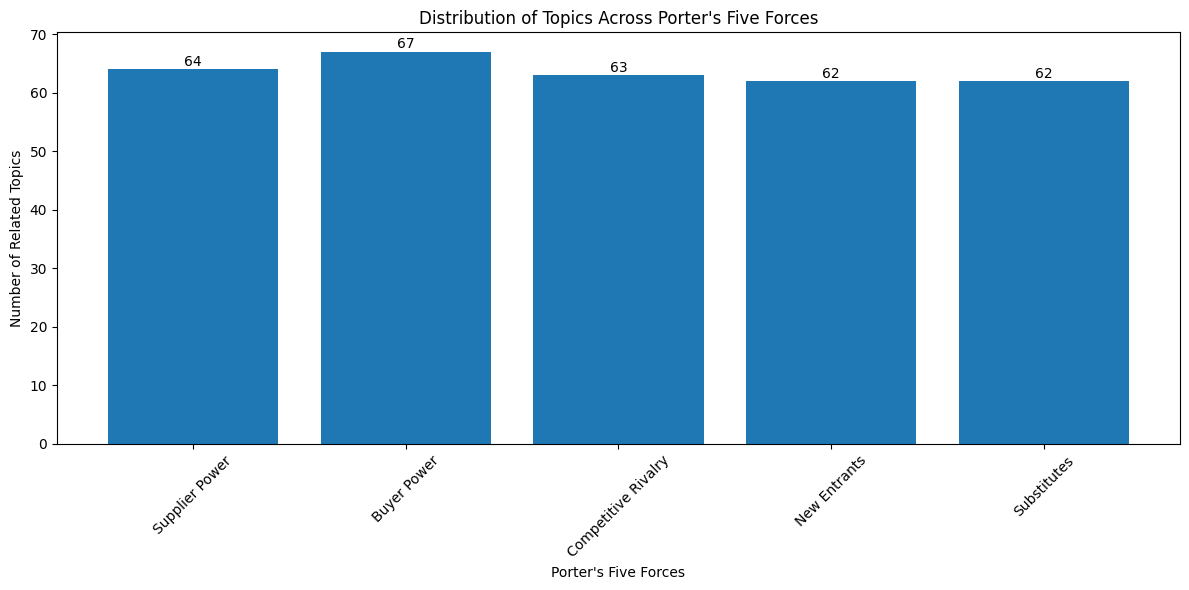


Mapping of Topics to Porter's Five Forces:

Supplier Power:
Found 64 related topics: [0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]

Topic 0:
Words: dishwasher, inalsa, smart, , , , , , , 
Matched words: , , , , , , , , , , , , , 
Average intensity: 0.00
Dominant sentiment: neutral
Sample document:
Nan

Topic 1:
Words: wonderful, , , , , , , , , 
Matched words: , , , , , , , , , , , , , 
Average intensity: 0.49
Dominant sentiment: positive
Sample document:
Wonderful

Topic 3:
Words: worth, brilliant, good, , , , , , , 
Matched words: , , , , , , , , , , , , , 
Average intensity: 0.38
Dominant sentiment: positive
Sample document:
Worth every penny

Topic 5:
Words: super, beast, stars, , , , , , , 
Matched words: , , , , , , , , , , , , , 
Average intensity: 0.50
Dominant sentiment: posi

In [29]:
# 9.8 Porter's Five Forces Analysis using Topics and Semantic Intensity
print("Connecting topics to Porter's Five Forces dimensions...")

try:
    # Define keywords for each dimension with expanded vocabulary
    force_keywords = {
        'supplier_power': ['supplier', 'vendor', 'inventory', 'delivery', 'shortage', 'delay', 'stock', 
                          'warehouse', 'shipment', 'parts', 'materials', 'component', 'input', 'manufacturing'],
        'buyer_power': ['customer', 'buyer', 'demand', 'feedback', 'return', 'refund', 'discount', 'price', 
                       'bargain', 'negotiate', 'deal', 'purchase', 'value', 'consumer', 'client', 'shopper'],
        'competitive_rivalry': ['competitor', 'competition', 'alternative', 'similar', 'market', 'industry', 
                              'rival', 'brand', 'comparison', 'compared', 'better', 'worse', 'leader'],
        'new_entrants': ['new', 'startup', 'innovative', 'disrupt', 'emerging', 'novel', 'fresh', 'launch', 
                        'entry', 'entrant', 'began', 'introduce', 'breakthrough', 'release'],
        'substitutes': ['substitute', 'alternative', 'replacement', 'instead', 'option', 'choice', 'switch', 
                       'changed', 'swap', 'different', 'another', 'prefer', 'upgraded', 'downgraded']
    }
    
    # Function to map topics to Porter's Five Forces dimensions with improved algorithm
    def map_topics_to_forces(topic_model, force_keywords, min_match=1):
        """Map topics to Porter's Five Forces with better keyword matching and scores."""
        force_topics = {force: [] for force in force_keywords.keys()}
        force_topic_scores = {}
        
        # Process each topic
        for topic_id in range(-1, len(topic_model.get_topic_info())-1):
            if topic_id == -1:  # Skip outlier topic
                continue
                
            try:
                # Get topic words and their weights
                topic_words = dict(topic_model.get_topic(topic_id))
                
                # Calculate match score for each force
                for force, keywords in force_keywords.items():
                    score = 0
                    matches = 0
                    matched_words = []
                    
                    for keyword in keywords:
                        for word in topic_words.keys():
                            # Check if keyword is contained in the word or vice versa
                            if keyword in word or word in keyword:
                                weight = topic_words[word]
                                score += weight
                                matches += 1
                                matched_words.append(word)
                    
                    # If enough matches, store this topic for this force
                    if matches >= min_match:
                        force_topics[force].append(topic_id)
                        force_topic_scores[(force, topic_id)] = {
                            'score': score,
                            'matches': matches,
                            'matched_words': matched_words
                        }
            except Exception as e:
                print(f"Error processing topic {topic_id}: {e}")
                continue
                
        return force_topics, force_topic_scores
    
    # Map topics to Porter's Five Forces
    force_topics, force_topic_scores = map_topics_to_forces(topic_model, force_keywords)
    
    # Create a visualization of topics by force
    forces = list(force_keywords.keys())
    force_counts = [len(force_topics[force]) for force in forces]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar([f.replace('_', ' ').title() for f in forces], force_counts)
    
    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height}', ha='center', va='bottom')
                
    plt.xlabel("Porter's Five Forces")
    plt.ylabel('Number of Related Topics')
    plt.title("Distribution of Topics Across Porter's Five Forces")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display the mapping with topic words and intensity
    print("\nMapping of Topics to Porter's Five Forces:")
    for force, topics in force_topics.items():
        if topics:
            print(f"\n{force.replace('_', ' ').title()}:")
            print(f"Found {len(topics)} related topics: {topics}")
            
            # Display topic words for each topic with intensity information
            for topic_id in topics:
                try:
                    # Get topic words
                    topic_words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                    
                    # Get match information
                    match_info = force_topic_scores.get((force, topic_id), {'score': 0, 'matches': 0, 'matched_words': []})
                    
                    # Get sentiment and intensity information
                    topic_df = df_sentiment[df_sentiment['topic'] == topic_id]
                    avg_intensity = topic_df['semantic_intensity'].mean() if 'semantic_intensity' in df_sentiment.columns else 0
                    
                    sentiment_counts = topic_df['semantic_sentiment'].value_counts() if 'semantic_sentiment' in df_sentiment.columns else None
                    dominant_sentiment = sentiment_counts.idxmax() if sentiment_counts is not None and not sentiment_counts.empty else 'unknown'
                    
                    # Print enriched topic information
                    print(f"\nTopic {topic_id}:")
                    print(f"Words: {topic_words}")
                    print(f"Matched words: {', '.join(match_info['matched_words'])}")
                    print(f"Average intensity: {avg_intensity:.2f}")
                    print(f"Dominant sentiment: {dominant_sentiment}")
                    
                    # Sample documents for this topic
                    if len(topic_df) > 0:
                        print("Sample document:")
                        sample = topic_df.sample(1).iloc[0]
                        print(f"  {sample['processed_text'][:150]}..." if len(sample['processed_text']) > 150 else sample['processed_text'])
                except Exception as inner_e:
                    print(f"Error displaying topic {topic_id}: {inner_e}")
    
    # Calculate overall force dominance
    if force_counts:
        dominant_force_idx = force_counts.index(max(force_counts))
        dominant_force = forces[dominant_force_idx].replace('_', ' ').title()
        print(f"\nDominant force in the analysis: {dominant_force} with {max(force_counts)} related topics")
    
except Exception as e:
    print(f"Error mapping topics to Porter's Five Forces: {e}")

In [30]:
# 9.9 Strategic Recommendations based on Combined Analysis
print("\nGenerating strategic recommendations based on combined analysis...")

try:
    # Create a summary of findings
    print("\n===== SUMMARY OF FINDINGS =====\n")
    
    # Check for required columns
    required_columns_present = all(col in df_sentiment.columns for col in ['topic', 'semantic_intensity', 'semantic_sentiment'])
    
    if required_columns_present:
        # 1. Identify high intensity negative topics
        high_intensity_negative = df_sentiment[
            (df_sentiment['semantic_sentiment'] == 'negative') & 
            (df_sentiment['semantic_intensity'] > 0.5)
        ]
        
        high_neg_topics = high_intensity_negative['topic'].value_counts()
        high_neg_topics = high_neg_topics[high_neg_topics > 2]  # At least 3 high-intensity negative reviews
        
        if not high_neg_topics.empty:
            print("1. Critical Areas of Concern (High-Intensity Negative Topics):")
            for topic_id, count in high_neg_topics.items():
                if topic_id != -1:  # Skipping outlier topics
                    try:
                        words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                        print(f"   - Topic {topic_id} ({count} high-intensity negative reviews): {words}")
                    except:
                        print(f"   - Topic {topic_id} ({count} high-intensity negative reviews)")
            print()
        else:
            print("1. No critical areas of concern identified.\n")
        
        # 2. Identify competitive advantages (positive topics with high intensity)
        high_intensity_positive = df_sentiment[
            (df_sentiment['semantic_sentiment'] == 'positive') & 
            (df_sentiment['semantic_intensity'] > 0.5)
        ]
        
        high_pos_topics = high_intensity_positive['topic'].value_counts()
        high_pos_topics = high_pos_topics[high_pos_topics > 2]  # At least 3 high-intensity positive reviews
        
        if not high_pos_topics.empty:
            print("2. Competitive Advantages (High-Intensity Positive Topics):")
            for topic_id, count in high_pos_topics.items():
                if topic_id != -1:  # Skip outlier topic
                    try:
                        words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                        print(f"   - Topic {topic_id} ({count} high-intensity positive reviews): {words}")
                    except:
                        print(f"   - Topic {topic_id} ({count} high-intensity positive reviews)")
            print()
        else:
            print("2. No clear competitive advantages identified.\n")
        
        # 3. Analysis of Porter's Five Forces
        print("3. Porter's Five Forces Analysis:")
        for i, force in enumerate(forces):
            print(f"   - {force.replace('_', ' ').title()}: {force_counts[i]} related topics")
            
            # Detailed analysis for forces with topics
            if force_counts[i] > 0:
                # Get sentiment breakdown for this force
                force_sentiment = {'positive': 0, 'negative': 0, 'neutral': 0}
                force_docs = 0
                
                for topic_id in force_topics[force]:
                    topic_docs = df_sentiment[df_sentiment['topic'] == topic_id]
                    force_docs += len(topic_docs)
                    
                    if 'semantic_sentiment' in topic_docs.columns:
                        sentiment_counts = topic_docs['semantic_sentiment'].value_counts()
                        for sentiment in force_sentiment.keys():
                            if sentiment in sentiment_counts:
                                force_sentiment[sentiment] += sentiment_counts[sentiment]
                
                # Calculate percentages if we have documents
                if force_docs > 0:
                    force_sentiment_pct = {k: (v/force_docs)*100 for k, v in force_sentiment.items()}
                    print(f"     Sentiment breakdown: Positive {force_sentiment_pct['positive']:.1f}%, " +
                          f"Negative {force_sentiment_pct['negative']:.1f}%, " +
                          f"Neutral {force_sentiment_pct['neutral']:.1f}%")
                    
                    # Derive insights
                    if force_sentiment_pct['negative'] > 50:
                        print(f"     Insight: High negative sentiment indicates vulnerability in {force.replace('_', ' ')}")
                    elif force_sentiment_pct['positive'] > 50:
                        print(f"     Insight: High positive sentiment suggests strength in {force.replace('_', ' ')}")
        print()
        
        # 4. Strategic Recommendations
        print("4. Strategic Recommendations:")
        
        # Determine overall competitive pressure
        competitive_rivalry_count = force_counts[forces.index('competitive_rivalry')] if 'competitive_rivalry' in forces else 0
        substitutes_count = force_counts[forces.index('substitutes')] if 'substitutes' in forces else 0
        
        if competitive_rivalry_count > 3 and substitutes_count > 2:
            competitive_pressure = "High"
        elif competitive_rivalry_count > 1 or substitutes_count > 1:
            competitive_pressure = "Moderate"
        else:
            competitive_pressure = "Low"
            
        print(f"   Overall competitive pressure: {competitive_pressure}")
        
        # Generate recommendations based on analysis
        print("\n   Specific recommendations:")
        if not high_neg_topics.empty:
            print("   - ADDRESS CRITICAL CONCERNS:")
            for topic_id in high_neg_topics.index[:3]:  # Top 3 negative topics
                if topic_id != -1:
                    try:
                        words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                        print(f"     > Improve {words} based on high-intensity negative feedback")
                    except:
                        pass
        
        if not high_pos_topics.empty:
            print("   - LEVERAGE STRENGTHS:")
            for topic_id in high_pos_topics.index[:3]:  # Top 3 positive topics
                if topic_id != -1:
                    try:
                        words = ", ".join([word for word, _ in topic_model.get_topic(topic_id)])
                        print(f"     > Highlight {words} in marketing and continue excellence")
                    except:
                        pass
        
        # Force-specific recommendations
        if competitive_pressure == "High":
            print("   - COMPETITIVE STRATEGY:")
            print("     > Strengthen differentiation in identified competitive vulnerability areas")
            print("     > Monitor competitor mentions closely in customer feedback")
            print("     > Develop targeted responses to specific competitive threats")
        elif competitive_pressure == "Moderate":
            print("   - COMPETITIVE STRATEGY:")
            print("     > Build on existing competitive advantages")
            print("     > Selectively address competitive weaknesses in high-priority areas")
            print("     > Monitor emerging competitive trends")
        else:
            print("   - COMPETITIVE STRATEGY:")
            print("     > Capitalize on low competitive pressure to build market dominance")
            print("     > Invest in innovation to maintain competitive advantage")
            print("     > Monitor for potential new entrants")
    else:
        print("Insufficient data for comprehensive strategic recommendations.")
        print("Required columns missing from the analysis.")
        
    # Save the analysis results
    try:
        # Save the topic model for future use
        print("\nSaving the topic model and analysis results...")
        topic_model.save("porter_five_forces_topic_model")
        df_sentiment.to_csv("topic_sentiment_intensity_analysis.csv", index=False)
        print("Analysis results saved successfully.")
    except Exception as save_e:
        print(f"Error saving results: {save_e}")
        
except Exception as e:
    print(f"Error generating strategic recommendations: {e}")


Generating strategic recommendations based on combined analysis...

===== SUMMARY OF FINDINGS =====

1. Critical Areas of Concern (High-Intensity Negative Topics):
   - Topic 41 (126 high-intensity negative reviews): hated hated, hated, , , , , , , , 
   - Topic 44 (125 high-intensity negative reviews): worst football, football, bad, worst, , , , , , 
   - Topic 37 (120 high-intensity negative reviews): poor, hard, ball, like, football, , , , , 
   - Topic 39 (115 high-intensity negative reviews): utterly, disappointed, , , , , , , , 
   - Topic 43 (112 high-intensity negative reviews): experience, worst, delivery flipkart, machine, delivery, flipkart, , , , 
   - Topic 47 (107 high-intensity negative reviews): bad quality, bad, quality, camera, quality good, working, fine, 678, black, cartridge
   - Topic 1 (50 high-intensity negative reviews): wonderful, , , , , , , , , 
   - Topic 4 (40 high-intensity negative reviews): great product, product great, great, product, product excellen

2025-05-15 13:45:29,715 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


     Sentiment breakdown: Positive 67.0%, Negative 7.6%, Neutral 25.4%
     Insight: High positive sentiment suggests strength in new entrants
   - Substitutes: 62 related topics
     Sentiment breakdown: Positive 67.0%, Negative 7.6%, Neutral 25.4%
     Insight: High positive sentiment suggests strength in substitutes

4. Strategic Recommendations:
   Overall competitive pressure: High

   Specific recommendations:
   - ADDRESS CRITICAL CONCERNS:
     > Improve hated hated, hated, , , , , , , ,  based on high-intensity negative feedback
     > Improve worst football, football, bad, worst, , , , , ,  based on high-intensity negative feedback
   - LEVERAGE STRENGTHS:
     > Highlight wonderful, , , , , , , , ,  in marketing and continue excellence
     > Highlight best, price, flipkart, service, good product, router, range, microwave, hp, need in marketing and continue excellence
   - COMPETITIVE STRATEGY:
     > Strengthen differentiation in identified competitive vulnerability areas
 